# Análisis exploratorio del IFN2 en Aragón

Selección de los mejores estadillos para el entrenamiendo de modelos de clasificación. Es previsible que se seleccionen más puntos de arbolado que de matorral, pues todas las parcelas del inventario se localizaron sobre superficie arbolada.

In [2]:
from pathlib import Path
import sys
import pandas as pd # type: ignore
import geopandas as gpd
import matplotlib.pyplot as plt # type: ignore

# ROOT = r"D:\iranzo\doctorado_v2\classification"
ROOT = r"C:\copia_seguridad\doctorado_v2\classification"
# NFI classes
module_path = Path(ROOT, "Python")
sys.path.append(str(module_path))
from ifn import Second # type: ignore

Se abren y se guardan juntas las tablas `DATEST`, `MATORR`, `IIFL03BD` y `PIESMA` de cada una de las tres provincias.

In [62]:
ifn2 = Second(Path(ROOT, r"data\labels\ifn\ifn2"))

Con el objetivo de añadir más información al análisis, se incluyen las coordenadas de los estadillos. No todos las tienen. Debido a que la componente espacial es necesaria para crear los modelos, solo se seleccionaran aquellos estadillos con coordenadas.

El archivo con las coordenadas está sacado del IFN4, por lo que solo tendrán coordenadas los estadillos que hayan sido revisitados.

In [63]:
fires_path = Path(ROOT, "data/fires.gpkg")
fires = gpd.read_file(fires_path) # EPSG:4326
fires["Year"] = fires["Year"].astype("int16")
# Add coordinates to damaged points
coord_path = Path(ROOT, "data/labels/ifn/coordinates/IFN4_crs_oficial.csv")
coord = pd.read_csv(coord_path)
coord = coord[['provincia', 'estadillo', 'X_WGS84_4326', 'Y_WGS84_4326']]
ifn2.datest_df = ifn2.datest_df.join(
    coord.set_index(['estadillo', 'provincia']), on=['ESTADILLO', 'PROVINCIA'])

In [64]:
# Create a geodataframe object
x_col = "X_WGS84_4326"
y_col = "Y_WGS84_4326"
crs = 'EPSG:4326'
geom = gpd.points_from_xy(
    ifn2.datest_df[x_col], ifn2.datest_df[y_col], crs=crs)
ifn2.datest_df = gpd.GeoDataFrame(ifn2.datest_df, geometry=geom)

## DATEST

Primero se comprueba la cantidad de datos nulos.

In [65]:
ifn2.datest_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6023 entries, 0 to 1363
Data columns (total 93 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PROVINCIA     6023 non-null   int8    
 1   ESTADILLO     6023 non-null   int16   
 2   ESTRATO       0 non-null      object  
 3   FECHGR        6023 non-null   int32   
 4   CODGR         6023 non-null   int8    
 5   NUMPMA        6023 non-null   int8    
 6   NUMTIP        6023 non-null   int8    
 7   NUMPME        6023 non-null   int8    
 8   NUMMAT        6023 non-null   int8    
 9   VERIFICA      6023 non-null   object  
 10  FECHAVE       6023 non-null   int32   
 11  CODVE         6023 non-null   int8    
 12  HOJA          6023 non-null   int16   
 13  VUELO         6023 non-null   int8    
 14  FOTO          6023 non-null   object  
 15  COORDEX       6023 non-null   int16   
 16  COORDEY       6023 non-null   int16   
 17  ANO           6023 non-null   int8    
 18  MUNIC

Todas las columnas contienen todos sus datos válidos y sin ninguna ausencia excepto `ESTRATO`.

### Período de los trabajos

Comprobar los años de realización del inventario en Aragón. 

Este dato es importante para la clasificación, pues en función del año se seleccionará la imagen Landsat correspondiente. Si un punto se coloca en un año incorrecto, los datos asociados al mismo no serán válidos, y es que la imagen de satélite podría estar reflejando una situación completamente diferente.

In [66]:
years = ifn2.datest_df['ANO'].astype("category")
print(pd.DataFrame({
  'year_count': years.value_counts(),
  'year_freq.': years.value_counts(normalize=True)
}).to_markdown())

|   ANO |   year_count |   year_freq. |
|------:|-------------:|-------------:|
|    93 |         3791 |  0.629421    |
|    94 |         2218 |  0.368255    |
|    50 |            4 |  0.000664121 |
|    91 |            3 |  0.000498091 |
|    92 |            3 |  0.000498091 |
|    22 |            1 |  0.00016603  |
|    33 |            1 |  0.00016603  |
|    90 |            1 |  0.00016603  |
|    95 |            1 |  0.00016603  |


De los 6023 registros, más de la mitad se llevaron a cabo en el año 1993 y más de un tercio en 1994.

In [67]:
years_prov = ifn2.datest_df.groupby(['PROVINCIA', 'ANO']).count()
years_prov = years_prov.reset_index()

print(pd.DataFrame({
  'Provincia': years_prov["PROVINCIA"],
  'year': years_prov["ANO"],
  'count': years_prov["ESTADILLO"]
}).to_markdown())


|    |   Provincia |   year |   count |
|---:|------------:|-------:|--------:|
|  0 |          22 |     22 |       1 |
|  1 |          22 |     33 |       1 |
|  2 |          22 |     91 |       1 |
|  3 |          22 |     92 |       2 |
|  4 |          22 |     93 |    2424 |
|  5 |          22 |     94 |       2 |
|  6 |          44 |     91 |       1 |
|  7 |          44 |     93 |      11 |
|  8 |          44 |     94 |    2215 |
|  9 |          44 |     95 |       1 |
| 10 |          50 |     50 |       4 |
| 11 |          50 |     90 |       1 |
| 12 |          50 |     91 |       1 |
| 13 |          50 |     92 |       1 |
| 14 |          50 |     93 |    1356 |
| 15 |          50 |     94 |       1 |


Al representar un conteo de los valores en la columna `ANO` por provincia, se observa que los códigos 22 y 50 pueden deberse a errores en la transcripción, incluyendo el código de provincia en la columna de los años.

Además de prescindir de los años 22 y 50 por el motivo anterior, también se descartan el resto, exceptuando el 1993 y el 1994, debido a su escasa representatividad respecto del total.

### Especie

Estudiar la distribución de los tres tipos de columnas que contienen datos sobre la especie.

In [68]:
# Open DF with veg codes
esp_ifn_codes_path = Path(ROOT, r"data\labels\label_ifn_codes.csv")
esp_ifn_codes_df = pd.read_csv(esp_ifn_codes_path)

In [69]:
# Counting the species values giving the keys in ESPECIA12
esa1 = ifn2.datest_df['ESPECIA12']
esb1 = ifn2.datest_df['ESPECIB1'].astype("category")
esp1 = ifn2.datest_df['ESPECIE1'].astype("category")

# Dataframe with species codes as indexes and the counting of each species cols
species_count = pd.DataFrame({
    'ESPECIA12': esa1.value_counts(),
    'ESPECIB1': esb1.value_counts(),
    'ESPECIE1': esp1.value_counts()
}).sort_values('ESPECIA12').join(esp_ifn_codes_df.set_index('code'))

Text(0.5, 1.0, 'ESPECIA12 > 50 valores')

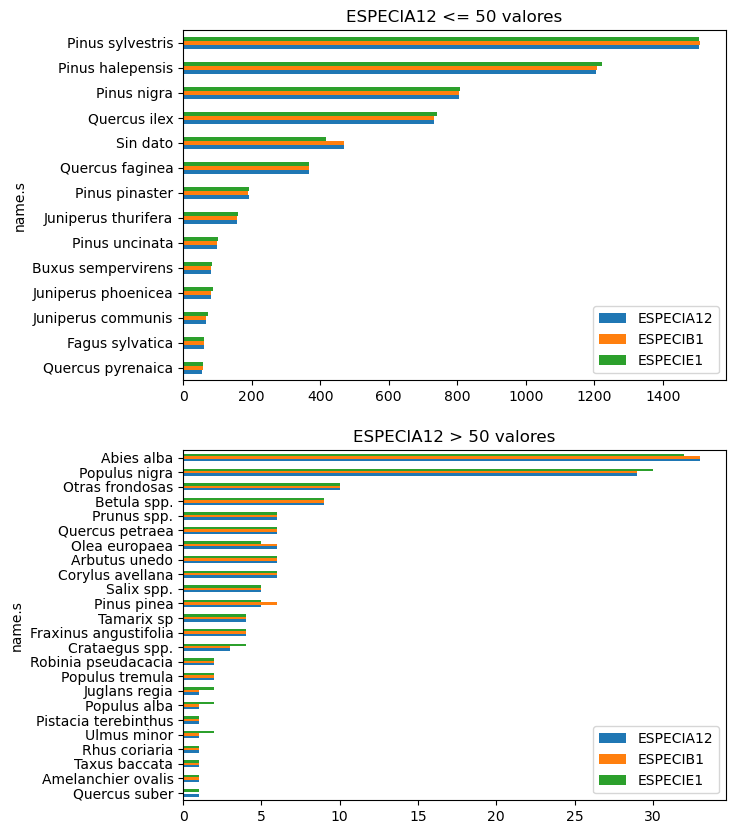

In [70]:
fig, axs = plt.subplots(2, 1, figsize=(7,10))
species_count.query('ESPECIA12 <= 50').plot(kind="barh", x="name.s", ax=axs[1])
species_count.query('ESPECIA12 > 50').plot(kind="barh", x="name.s", ax=axs[0])
axs[0].set_title("ESPECIA12 <= 50 valores")
axs[1].set_title("ESPECIA12 > 50 valores")

Existen 469 datos sin especia principal (código 0) en las columnas `ESPECIA12` y `ESPECIB1`, y 416 en la columna `ESPECIE1`. Comprobar si estos estadillos no contienen especia principal porque se trata de parcelas matorrales.

El número de especies en cada una de las columnas es muy similar.

Comprobar el número de columnas iguales en el DF. Primero se crea una nueva columna que contiene los nombres de las columnas con valores idénticos.

Esta operación se realiza con el método `apply`:

 - `df.apply()` con `axis=1` aplica la función por filas.
 - `row.eq(row.iloc[0])` comprueba si cada elemento en la fila es igual al primer elemento de la misma. Devuelve como resultado un `array` boleano.
 - `row.index[row.eq(row.iloc[0])]` selecciona los índices (nombres de columna) donde la condición es verdadera.
 - `.tolist()` convierte el resultado en una lista de nombres de columna donde los valores son iguales.

> This method is efficient and takes advantage of `pandas` vectorized operations, which are typically faster than iterating over the rows with a loop.

In [71]:
def create_equal_cols(data, cols = ['ESPECIA12', 'ESPECIE1', 'ESPECIB1']):
    """Select plots with the same code in the three main species columns"""
    df = data.copy()
    # Function to compare cols values
    compare = lambda row: ','.join(row.index[row.eq(row.iloc[0])].tolist())
    # Create the new column with the column names containing the same code
    equal_col = df[cols].apply(compare, axis=1)
    df['Equal_Columns'] = equal_col
    return df

In [72]:
cols = ['ESPECIA12', 'ESPECIE1', 'ESPECIB1']
datest_df = create_equal_cols(ifn2.datest_df, cols)

print(datest_df['Equal_Columns'].value_counts())

Equal_Columns
ESPECIA12,ESPECIE1,ESPECIB1    5947
ESPECIA12,ESPECIB1               67
ESPECIA12,ESPECIE1                9
Name: count, dtype: int64


La práctica totalidad de los datos tiene un valor de especie idéntico en las tres columnas.

Si se muestran los datos de cobertura (Ocupación y FCC), se observa una media alta en aquellos estadillos donde la ESPECIE1 coincida con alguna de las otras dos.

In [73]:
describe_cols = ['OCUPA12', 'FRACCION2']
for col in describe_cols:
    idx_col = 'Equal_Columns'
    print(datest_df[[idx_col, col]].groupby(idx_col).describe())

                            OCUPA12                                          \
                              count      mean       std  min  25%  50%  75%   
Equal_Columns                                                                 
ESPECIA12,ESPECIB1             67.0  1.044776  2.351227  0.0  0.0  0.0  0.0   
ESPECIA12,ESPECIE1              9.0  4.888889  3.586239  0.0  3.0  5.0  9.0   
ESPECIA12,ESPECIE1,ESPECIB1  5947.0  5.443753  3.234940  0.0  4.0  6.0  8.0   

                                  
                             max  
Equal_Columns                     
ESPECIA12,ESPECIB1           9.0  
ESPECIA12,ESPECIE1           9.0  
ESPECIA12,ESPECIE1,ESPECIB1  9.0  
                            FRACCION2                                          \
                                count       mean        std   min   25%   50%   
Equal_Columns                                                                   
ESPECIA12,ESPECIB1               67.0   7.895522  19.296046   0.0   0.0 

Una vez seleccionada la columna ESPECIE1 para determinar la especie dominante, se comprueba la distribución por provincias de las especies a clasificar.

In [74]:
esp_codes_path = Path(ROOT, r"data\labels\label_codes.csv")
esp_codes_df = pd.read_csv(esp_codes_path)

datest_prun = datest_df.join(esp_codes_df.set_index("code_ifn"), on="ESPECIE1")
# Select valid vegetation types
datest_prun.query("label.notna() or ESPECIE1 == 0")["ESPECIE1"].value_counts()

ESPECIE1
21    1507
24    1222
25     808
45     741
0      416
44     366
26     192
38     159
22     101
71      62
Name: count, dtype: int64

La distribución por provincias se asemeja a la realidad, siendo mayor el número de estadillos cuya especie principal es *Pinus halepensis* en Zaragoza, siendo en Huesca y Teruel totalmente distinta.

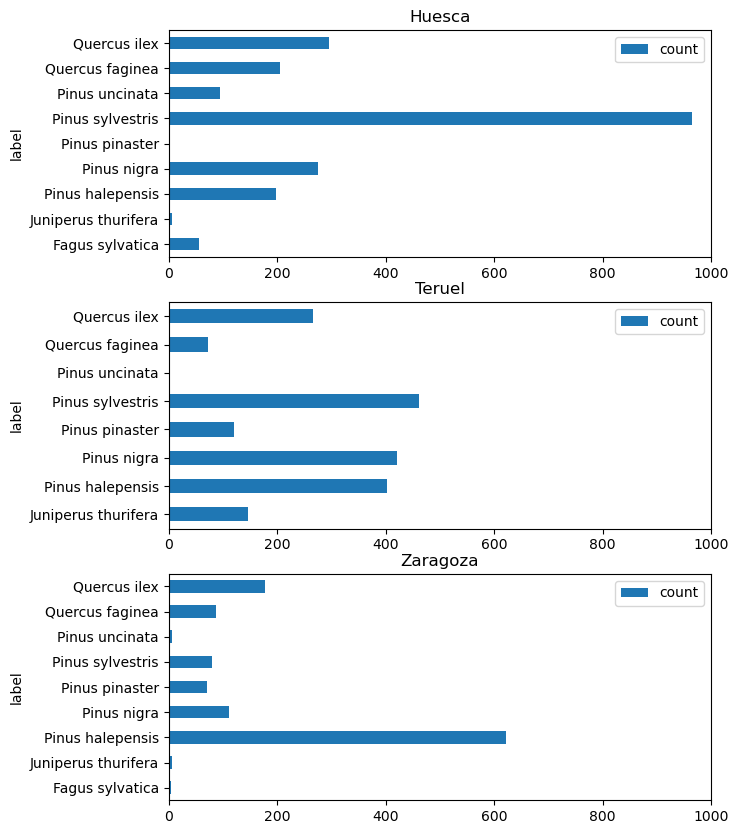

In [75]:
veg_prov = datest_prun.groupby(['PROVINCIA', 'label']).count()
veg_prov = veg_prov.reset_index()
veg_prov = pd.DataFrame({
  'Provincia': veg_prov["PROVINCIA"],
  'label': veg_prov["label"],
  'count': veg_prov["ESTADILLO"]
})

fig, axs = plt.subplots(3, 1, figsize=(7, 10))
prov_dict = {"Huesca": 22, "Teruel": 44, "Zaragoza": 50}
for i, (prov, code) in enumerate(prov_dict.items()):
    prov_q = f"Provincia == {code}"
    veg_prov.query(prov_q).plot(
        kind="barh", x="label", y="count", xlim=(0, 1000), ax=axs[i])
    axs[i].set_title(prov)

### Especies secundarias

Los estadillos filtrados por las 9 especies forestales del proyecto PaF contienen especies secundarias. De momento, se ha descartado generar etiquetas por cada combinación, demasiado número de combinaciones (> 170).

In [76]:
# datest_prun.groupby(['ESPECIE1', 'ESPECIE2']).size().unstack(fill_value=0)

### Ocupación

> En «Ocupación» se mide el grado de presencia de las especies halladas en la parcela. Se expresará en tantos por cientos con la cifra de las decenas. Si hay una sola especie la ocupación será el ciento por ciento y se pondrá un cero (0) en la correspondiente casilla. (p 101 del PDF de métodos.)

La columna `OCUPA12` contiene información del porcentaje de ocupación de la especie principal tomada en campo.

In [77]:
datest_prun['OCUPA12'].describe()

count    6023.000000
mean        5.393990
std         3.259405
min         0.000000
25%         4.000000
50%         6.000000
75%         8.000000
max         9.000000
Name: OCUPA12, dtype: float64

La ocupación media es similar en las tres provincias.

In [78]:
datest_prun[['PROVINCIA', 'OCUPA12']].groupby('PROVINCIA').describe()

OCUPA12                                             
            count      mean       std  min  25%  50%  75%  max
PROVINCIA                                                     
22         2431.0  5.977787  2.706249  0.0  5.0  6.0  8.0  9.0
44         2228.0  5.017056  3.441431  0.0  0.0  6.0  8.0  9.0
50         1364.0  4.969208  3.675453  0.0  0.0  6.0  9.0  9.0

No existen ocupaciones del 20% en las especies seleccionadas.

<Axes: ylabel='OCUPA22'>

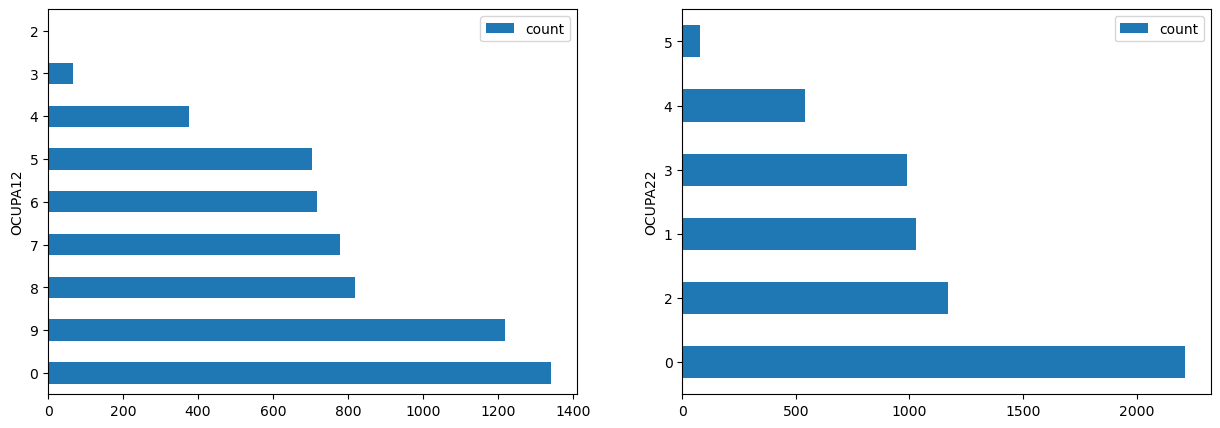

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
datest_prun['OCUPA12'].value_counts().reset_index().plot(x='OCUPA12', y='count', ax=axs[0], kind="barh")
datest_prun['OCUPA22'].value_counts().reset_index().plot(x='OCUPA22', y='count', ax=axs[1], kind="barh")

Entre los estadillos cuya especie principal sea una de las analizadas, son muy pocos aquellos en los que su especie principal esté por debajo de 4. El problema de la ocupación es su valor 0. ¿Todos los estadillos cuya Ocupación de la especie principal es 0 esta ocupa el 100%?

Siempre que la ocupación de la primera especie es 0, la segunda especie también lo es. Todo parece indicar que si la primera especie ocupa el total de la parcela la segunda especie no tiene ocupación.

Text(0.5, 1.0, 'OCUPA22 cuando OCUPA12 == 0')

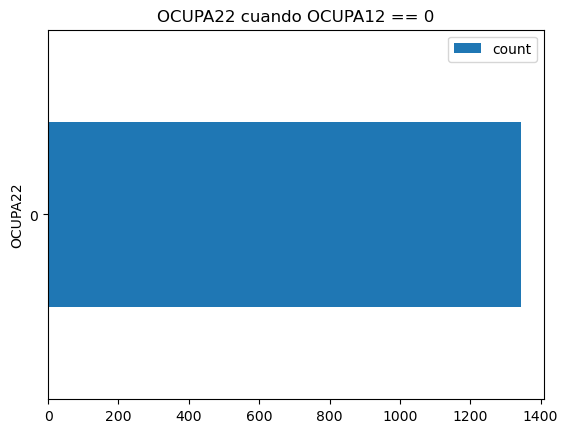

In [80]:
fig, ax = plt.subplots(1, 1)
ocu2=datest_prun.query("OCUPA12 == 0")["OCUPA22"].value_counts().reset_index()
ocu2.plot(x="OCUPA22", y="count", ax=ax, kind="barh")
ax.set_title("OCUPA22 cuando OCUPA12 == 0")

El promedio de ocupación por especie podría variar si se utilizara un 10 en lugar de un 0 para aquellos estadillos con ocupacíon de 100%. Hay que tener cuidado, ya que algunos valores 0 podrían indicar estadillos con nula cobertura forestal.

<Axes: ylabel='label'>

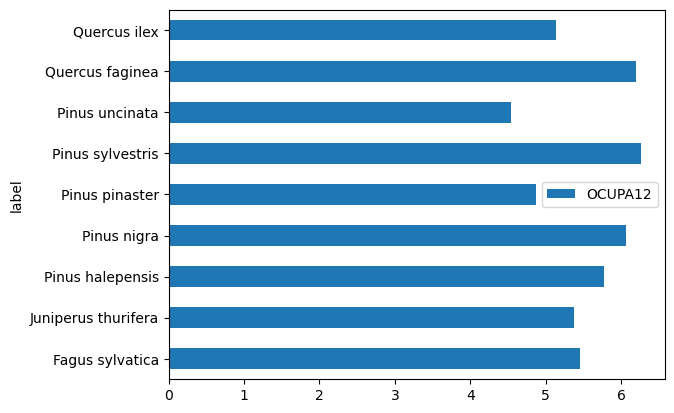

In [81]:
datest_prun.groupby('label')["OCUPA12"].mean().reset_index().plot(kind="barh", y="OCUPA12", x="label")

Al cambiar los valores, Pinus uncinata es el que mayor promedio de ocupación tiene seguido de Quercus ilex y Pinus halepensis.

<Axes: ylabel='label'>

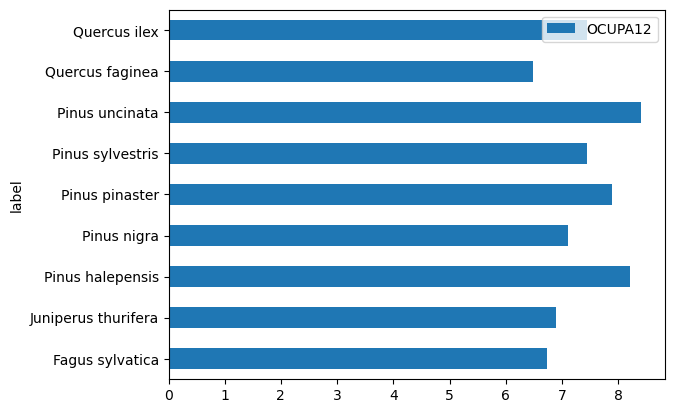

In [82]:
datest_prun['OCUPA12'] = datest_prun['OCUPA12'].replace(0, 10)
datest_prun.groupby('label')["OCUPA12"].mean().reset_index().plot(kind="barh", y="OCUPA12", x="label")

### Fracción de Cabida Cubierta (FCC)

> La fracción de cabida cubierta, o sea, el cociente de dividir la superficie proyectada ortogonalmente sobre el suelo de todas las copas de los árboles de la parcela por el área de dicha parcela, **se estimará sin medición a criterio del jefe de equipo**. En las casillas se pondrá la cifra en tantos por ciento y cuando toda la superficie esté cubierta por las copas se pondrá 99.

La columna `FRACCION2` contiene la información sobre la FCC.

<Axes: ylabel='FRACCION2'>

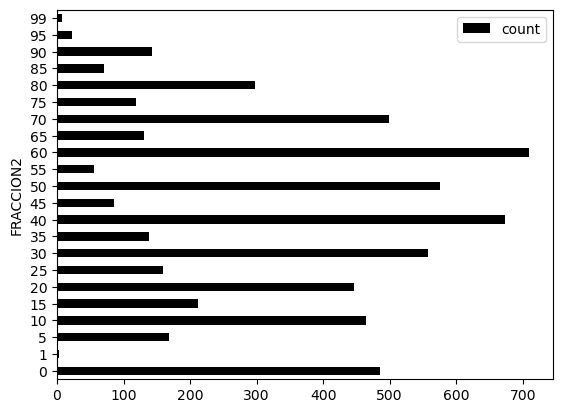

In [83]:
datest_prun['FRACCION2'].value_counts().sort_index().reset_index().plot(x="FRACCION2", kind="barh", colormap="grey")

Los valores de FCC están bastante repartidos en función de la ocupación de la primera especie. La media de FCC es ligeramente superior en ocupaciones de 7 y 8, siendo muy inferior en ocupaciones 10. Puntualizar que, en este último caso, la especie principal es la única en estar presente en la parcela, pero no quiere decir que sus copas la cubran al 100%.

In [84]:
datest_prun.groupby('OCUPA12').describe()['FRACCION2']

,count,mean,std,min,25%,50%,75%,max
OCUPA12,,,,,,,,
2,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0
3,67.0,39.850746,20.724933,0.0,25.0,40.0,60.0,80.0
4,376.0,41.178191,24.340094,0.0,20.0,40.0,60.0,99.0
5,704.0,42.572443,23.949102,0.0,20.0,40.0,60.0,95.0
6,717.0,42.895397,23.008292,0.0,25.0,40.0,60.0,99.0
7,779.0,47.839538,22.967982,5.0,30.0,50.0,65.0,99.0
8,818.0,47.841076,23.609775,5.0,30.0,50.0,70.0,99.0
9,1218.0,43.649425,23.052819,0.0,25.0,40.0,60.0,95.0
10,1343.0,28.093820,27.956617,0.0,0.0,20.0,50.0,95.0


Sin embargo, existen parcelas (más de 400) que aunque la especie principal ocupe el 100% (OCUPA12 == 10) sus copas no cubren la parcela. Estos son los casos en los que el código de la especie principal es 0. Por lo tanto, se descartan también estos casos.

<Axes: ylabel='FRACCION2'>

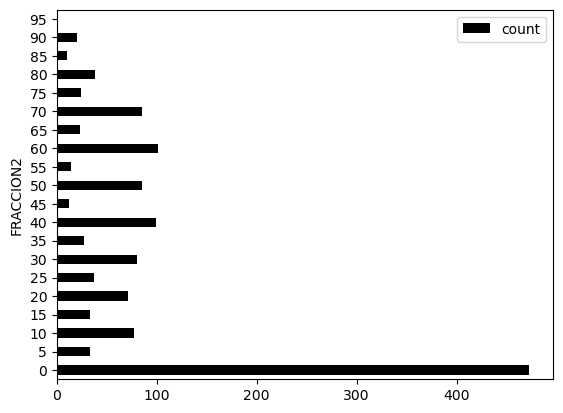

In [85]:
datest_prun.query("OCUPA12==10")['FRACCION2'].value_counts().sort_index().reset_index().plot(x="FRACCION2", kind="barh", colormap="grey")

<Axes: ylabel='label'>

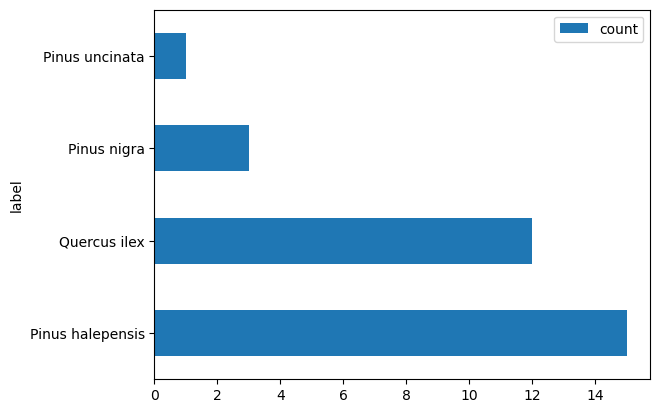

In [86]:
datest_prun.query("OCUPA12==10 and FRACCION2 == 0")["label"].value_counts().reset_index().plot(x="label", kind="barh")

In [87]:
datest_prun.query("OCUPA12==10 and FRACCION2 == 0")["ESPECIE1"].value_counts()

ESPECIE1
0     416
24     15
45     12
39     10
37      7
91      3
25      3
75      1
58      1
22      1
51      1
56      1
15      1
4       1
Name: count, dtype: int64

La especie con mayor porcentaje de FCC es *Fagus sylvatica*, y la de menos porcentaje es *Juniperus thurifera*. Todo apunta a que la FCC es la métrica a utilizar para filtrar los estadillos con un mayor porcentaje de la especie principal. De esta forma, los píxeles de Landsat harán referencia con mayor probabilidad a la etiqueta.

<Axes: ylabel='label'>

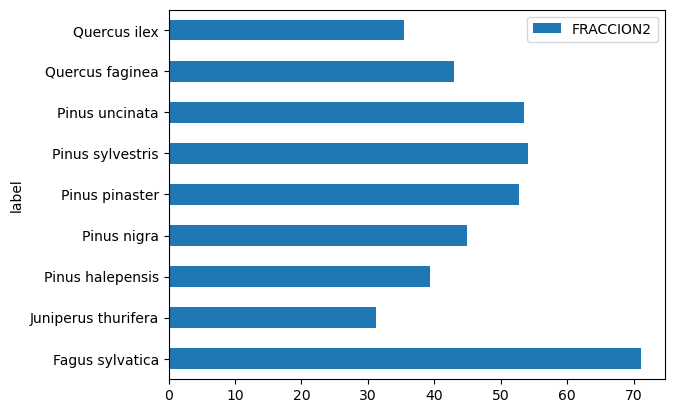

In [88]:
datest_prun.groupby('label')["FRACCION2"].mean().reset_index().plot(kind="barh", y="FRACCION2", x="label")

In [89]:
datest_prun.groupby('label')["FRACCION2"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Fagus sylvatica,62.0,71.096774,21.254669,5.0,56.25,80.0,90.0,99.0
Juniperus thurifera,159.0,31.257862,16.313470,5.0,20.00,30.0,40.0,70.0
Pinus halepensis,1222.0,39.404255,21.420831,0.0,20.00,40.0,60.0,95.0
Pinus nigra,808.0,44.863861,22.219894,0.0,30.00,45.0,60.0,95.0
Pinus pinaster,192.0,52.786458,20.705394,5.0,40.00,60.0,70.0,90.0
Pinus sylvestris,1507.0,54.156603,21.989963,5.0,40.00,60.0,70.0,99.0
Pinus uncinata,101.0,53.554455,22.254202,0.0,40.00,60.0,70.0,99.0
Quercus faginea,366.0,42.934426,23.469854,0.0,20.00,40.0,60.0,99.0
Quercus ilex,741.0,35.398111,21.256400,0.0,20.00,30.0,50.0,90.0


### Uso

1. Bosque, monte arbolado, superficie forestal arbolada.
2. Bosquete (no se usa en el 2 IFN).
3. Matorral, monte desarbolado, superficie forestal desarbolada.
4. Pastizal natural o con débil intervención humana.
5. Cultivos y prados con fuerte intervención humana.
6. Improductivo artificial.
7. Improductivo por aguas.
8. Improductivo natural.
9. Otros usos,

La mayoría de los usos se corresponden con una superficie boscosa (1), y la segunda con superficie de matorral (3).

|   USO2 |   count |
|-------:|--------:|
|      1 |    5354 |
|      3 |     463 |

In [90]:
datest_prun['USO2'].value_counts()

USO2
1    5354
3     463
2     171
5      24
0       5
6       3
9       1
4       1
8       1
Name: count, dtype: int64

Las especies de interés para la clasificación (aquellas en que la columna "ESPECIE1" coincide con las etiquetas de vegetación a clasificar) cuentan con muy pocos puntos de matorral. Sin embargo, estos pueden utilizarse como el estadio de matorral de la especie principal. Es curioso como, aunque son puntos de matorral, la ocupación de la primera especie tiene un promedio elevado, pero no así la FCC.

In [91]:
datest_prun.query("USO2 == 3").groupby(["label"]).count().sort_values(by="ESTADILLO")["ESTADILLO"]

label
Pinus uncinata       1
Pinus nigra          3
Quercus faginea      3
Quercus ilex        13
Pinus halepensis    17
Name: ESTADILLO, dtype: int64

<Axes: xlabel='OCUPA12 mean', ylabel='label'>

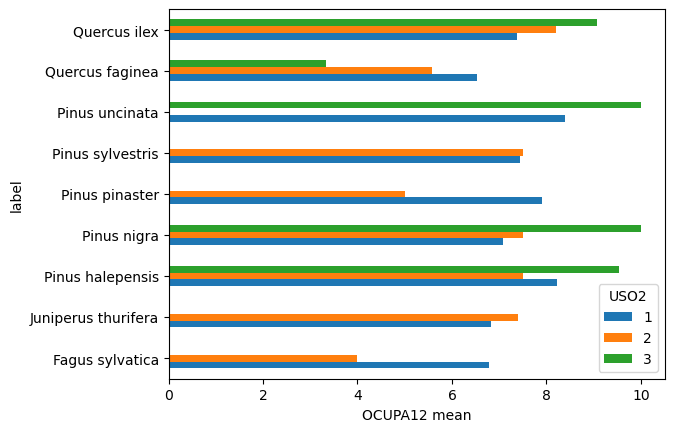

In [92]:
datest_prun.query("USO2 in [1,2,3]").groupby(['label', 'USO2'])['OCUPA12'].mean().unstack().plot(kind="barh", xlabel="OCUPA12 mean")

<Axes: xlabel='FCC mean', ylabel='label'>

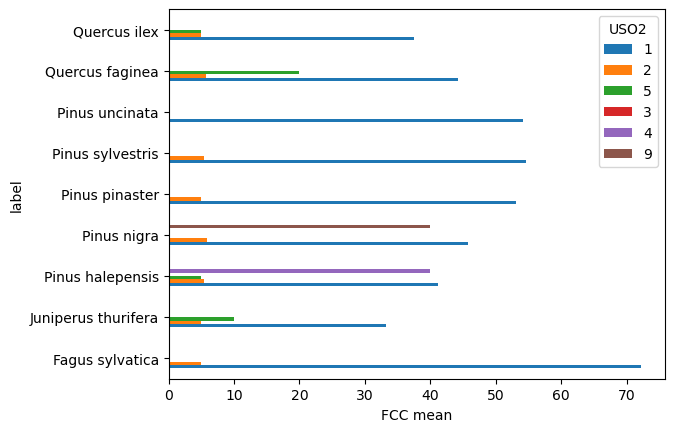

In [93]:
datest_prun.groupby(['label', 'USO2'])['FRACCION2'].mean().unstack().plot(kind="barh", xlabel="FCC mean")

### Estado

Los tipos de estado se guían por las definiciones de las clases naturales de edad siguientes:

1. Repoblado: Conjunto de pies procedentes de semilla, que desde el estrato herbáceo llega hasta el arbustivo y los pies inician la tangencia de las copas.
2. Monte bravo: Comprende desde el estrato y clase de edad anterior hasta el momento en que, por efecto del crecimiento, los pies empiezan a perder las ramas inferiores; es decir, que en esta clase de edad las ramas se encuentran a lo largo de todo el fuste.
3. Latizal: Comprende desde la clase anterior hasta que los pies tienen 20 cm de diámetro normal; es decir, el diámetro de su fuste, medido a la altura de 1,30m del suelo. Se divide en bajo latizal o vardascal, que comprende a todos los pies de esta clase con diámetro normal inferior a los 10 cm y alto latizal, que comprende los pies que tienen diámetros normales entre los 10 y
20 cm.
4. Fustal: Se caracteriza esta clase de edad, porque sus pies tienen diámetros normales superiores a 20 cm llamándose bajo o joven fustal a los pies con diámetros normales comprendidos entre 20 y 35 cm, fustal medio aquéllos que los tienen entre 35 y 50 cm y fustal viejo o alto fustal, cuando los diámetros normales son superiores a 50 cm.

Interesan todas las clases excepto la 1, por estar todavía en una fase de crecimiento.

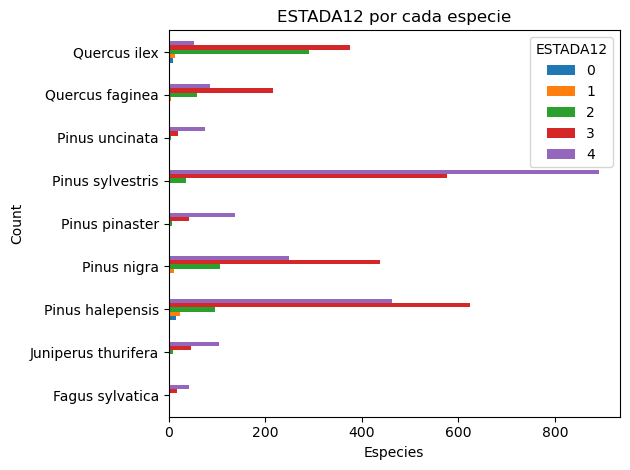

In [94]:
# Counting the species values giving the keys in ESTADA12
grpd = datest_prun.groupby(['label', 'ESTADA12']).size().unstack(fill_value=0)
grpd.plot(kind='barh')

plt.title('ESTADA12 por cada especie')
plt.xlabel('Especies')
plt.ylabel('Count')
plt.legend(title='ESTADA12')
plt.tight_layout()
plt.show()

Todas las especies cuentan con un mayor porcentaje de estadillos en los estados 3-4. La FCC aumenta con forme aumenta el tipo de estado (aumenta el diámetro de los árboles en la parcela). Por lo tanto, si se seleccionan parcelas con FCC alta no hace falta seleccionar por estado.

<Axes: xlabel='FCC mean', ylabel='label'>

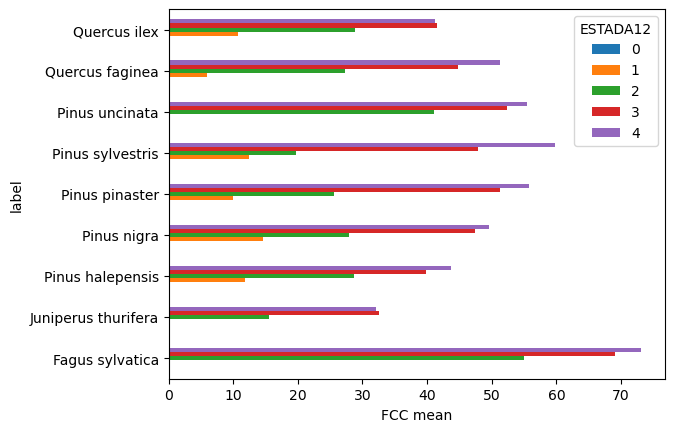

In [95]:
datest_prun.groupby(['label', 'ESTADA12'])['FRACCION2'].mean().unstack().plot(kind="barh", xlabel="FCC mean")

### Composición específica

1. Masas homogéneas o puras
2. Masas heterogéneas o mezcladas pie a pie
3. Masas heterogéneaso mezcladas con subpiso
9. Otras, o no sabe

Las especies analizadas presentan una multitud de casuísticas.

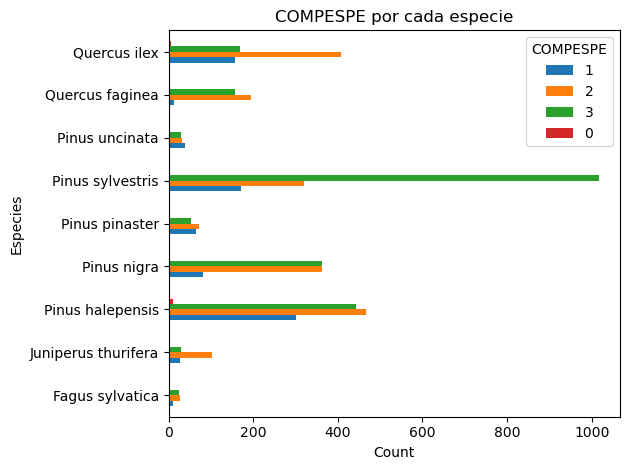

In [96]:
# Counting the species values giving the keys in COMPESPE
grpd = datest_prun.groupby(['label', 'COMPESPE']).size().unstack(fill_value=0)
grpd.plot(kind='barh')

plt.title('COMPESPE por cada especie')
plt.xlabel('Count')
plt.ylabel('Especies')
plt.legend(title='COMPESPE')
plt.tight_layout()
plt.show()

al realizar la media de ocupación por composición específica, la composición de tipo 1 (puras) es la que mayor promedio tiene junto con la 0 (errores).

<Axes: xlabel='OCUPA12 mean', ylabel='label'>

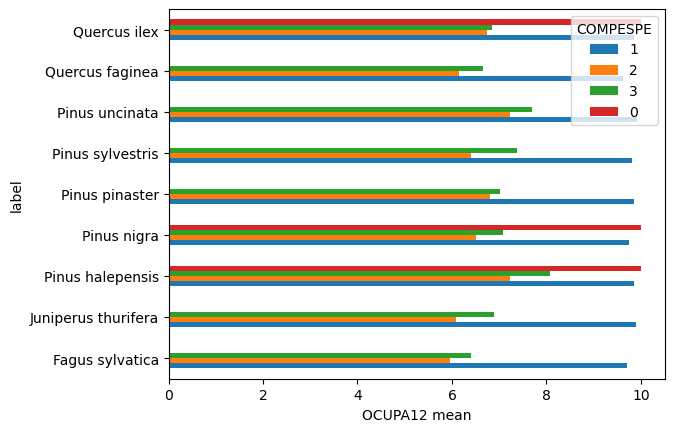

In [97]:
datest_prun.groupby(['label', 'COMPESPE'])['OCUPA12'].mean().unstack().plot(kind="barh", xlabel="OCUPA12 mean")

Al realizar el promedio por FCC ya no salen los errores.

<Axes: xlabel='FCC mean', ylabel='label'>

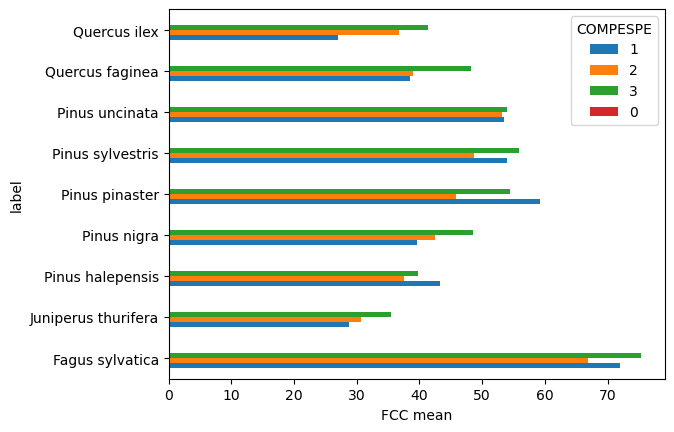

In [98]:
datest_prun.groupby(['label', 'COMPESPE'])['FRACCION2'].mean().unstack().plot(kind="barh", xlabel="FCC mean")

### Distribución espacial

1. Uniforme
2. Diseminada en bosquetes aislados
3. Diseminada en individuos aislados
9. Otras, o no sabe

La mayoría de estadillos pertenecen a la clase 1, que también presenta los mayores valores de FCC y ocupación promedios. Por lo tanto, cuando se filtra por FCC se eliminan los menos de 30 puntos de *Pinus halepensis* con un DISESPAC diseminado.

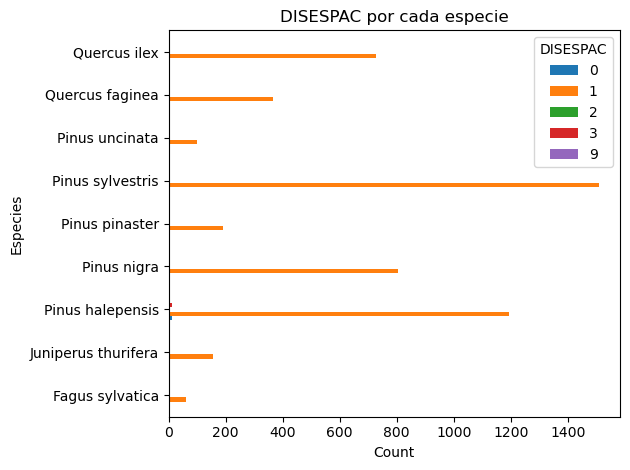

In [99]:
grpd = datest_prun.groupby(['label', 'DISESPAC']).size().unstack(fill_value=0)
grpd.plot(kind='barh')

plt.title('DISESPAC por cada especie')
plt.xlabel('Count')
plt.ylabel('Especies')
plt.legend(title='DISESPAC')
plt.tight_layout()
plt.show()

<Axes: xlabel='FCC', ylabel='label'>

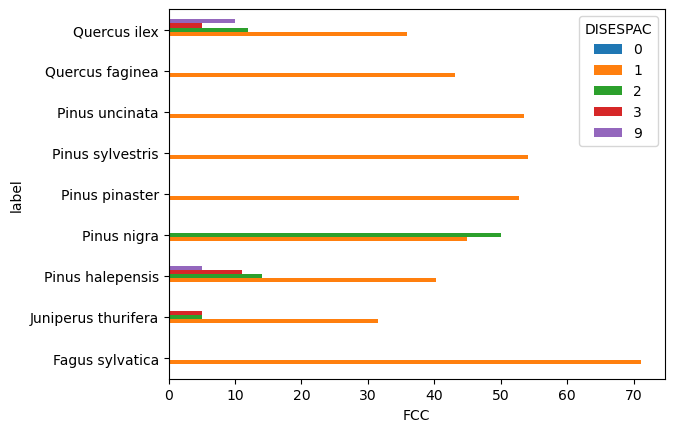

In [100]:
datest_prun.groupby(['label', 'DISESPAC'])['FRACCION2'].mean().unstack().plot(kind="barh", xlabel="FCC")

### Daños por fuego

Las tres columnas de daños, diseñadas para incluir las causas y la incidencia de factores degradantes de la masa forestal, incluyen un código de daños por fuego. Son las columnas que acaban por 12.

Existen 189 estadillos dañados por fuego.


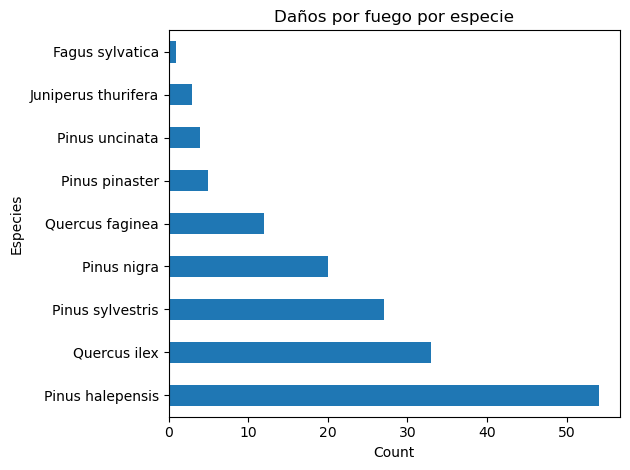

In [101]:
# Select only damages by fire (12)
queries = []
for col_n in range(1, 4):
    col = 'DANOS' + str(col_n)
    mask = datest_prun[col].notnull() & datest_prun[col].str.endswith('12')
    queries.append(mask)

danos_fuego = datest_prun[queries[0] | queries[1] | queries[2]]
print(f"Existen {danos_fuego.shape[0]} estadillos dañados por fuego.")
danos_fuego["label"].value_counts().plot(kind='barh')

plt.title('Daños por fuego por especie')
plt.xlabel('Count')
plt.ylabel('Especies')
plt.tight_layout()
plt.show()

Sin embargo, las parcelas dañadas tienen muy poca fracción cabida cubierta.

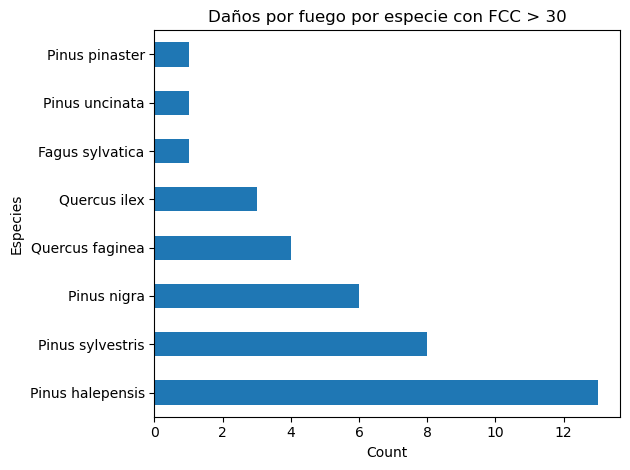

In [102]:
danos_fuego.query("FRACCION2 > 30")["label"].value_counts().plot(kind='barh')

plt.title('Daños por fuego por especie con FCC > 30')
plt.xlabel('Count')
plt.ylabel('Especies')
plt.tight_layout()
plt.show()

Además, las parcelas con daños por fuego no siempre son parcelas de USO2 == 3 (matorral).

In [103]:
danos_fuego["USO2"].value_counts()

USO2
1    147
2     32
3      9
5      1
Name: count, dtype: int64

¿Están las parcelas dañadas por fuego sobre incendios de PaF? En ese caso, podrían considerarse como etiquetas de matorral de su especie principal.

In [104]:
points_within = gpd.sjoin(
    danos_fuego, fires, how="inner", predicate="within")
print(f"Existen {points_within.shape[0]} parcelas dañadas por fuego sobre un incendio PaF.")

Existen 62 parcelas dañadas por fuego sobre un incendio PaF.


Sin embargo, hay que volver a filtrarlos. Solo interesan los incendios ocurridos a partir de 1985 (imágenes Landsat a partir del 84 y se necesita un año de pre fuego) y antes del 93 (cuando empiezan los trabajos del IFN2). Si se recogieran incendios posteriores la vegetación reflejaría el estadio quemado del incendio.

Se entiende que la regeneración, si es posterior a 10 años, no es suficiente como para configurar una nueva categoría forestal.

> TODO: Incluir la severidad para seleccionar estos puntos.

In [105]:
points_within["Year"].value_counts().sort_index()

Year
1975     1
1979     4
1980     1
1981     7
1982     4
1983     2
1984     5
1986    12
1987     1
1988     2
1989     3
1990     3
1991     9
1993     3
1994     2
2009     2
2015     1
Name: count, dtype: int64

## IIFL03BD

Estas tablas contienen valores modulares por especie y estadillo. Son de especial interés las variables diamétricas de la cobertura arbórea en la parcela.

El objetivo es comprobar que valores de FCC contienen un mayor número de árboles de porte superior, de forma que sea más fácil la clasificación posterior con los valores de la imagen Landsat.

> Aparecen para cada una de las especies y clase diamétrica de la parcela, los valores modulares calculados con las tarifas y ecuaciones que se aplicaron en cada caso (ver publicación provincial correspondiente). Los valores de volumen se expresan en $m^3/ha$ y los areales en metro cuadrado. Los valores que se consideran son: Volumen con Corteza (VCC), Volumen sin Corteza (VSC), Incremento anual del VCC (IAVC), Volumen de Leñas (VLE) y Área Basimétrica (AB).

In [106]:
iifl_col_names = {
    "NVCC": "Volumen con Corteza (m3/ha)",
    "NVSC": "Volumen sin Corteza (m3/ha)",
    "NIAVC": "Incremento anual del VCC (m3/ha)",
    "NVLE": "Volumen de Leñas (m3/ha)",
    "NAREAB": "Área Basimétrica (m2)",
    "NARBOLES": "Conteo de árboles en la parcela (?)",
    "CCDIAMETR": "Diámetro"
}

Se utilizan los valores agrupados (IFL03BD) en lugar de los valores por árbol y estadillo de la tabla IFL00BD. El motivo, la agrupación se ha hecho con parámetros técnicos precisos (p 128 del pdf de métodos). A pesar de hablar de valores calculados por área, sigue habiendo diferentes valores en cada estadillo en función de la especie.

Cuidado: en el pdf de métodos existe una columna con la clase diamétrica clase diamétrica (p 128 del pdf de métodos):

- C.D. 1: Pies de diámetro normal (75 - 124 mm) + distancia al rejón <= 5 m 
- C.D. 2: Pies entre 125 - 224 mm + distancia al rejón <= 10 m.
- C.D. 3: Pies entre 225 - 424 mm + distancia al rejón <= 15 m.
- C.D. 4: Pies de diámetro normal > 425 mm + distancia al rejón <= 25 m.

Esta no aparece en las tablas de IFL03BD. Sin embargo, aparece `CCDIAMETR` que parece contener el diámetro de los árboles en el estadillo.

*Nota: el diámetro normal se mide a 1,30m del suelo*.

In [107]:
ifn2.ifl_df.head()

,PROVINCIA,ESTADILLO,CESPECIE,CCDIAMETR,NARBOLES,NVCC,NVSC,NVLE,NIAVC,NAREAB
0,22,1,71,15,127.32,5.018705,4.118998,0.981442,0.518381,2.400312
1,22,1,71,20,127.32,9.870777,8.755241,1.944810,0.590726,4.286595
2,22,1,71,30,28.29,5.788338,5.314797,0.991133,0.184067,1.911496
3,22,1,71,35,14.14,2.710538,2.487910,0.788090,0.089413,1.412125
4,22,1,71,40,28.29,15.273006,14.150980,2.232074,0.318464,3.782309


In [108]:
iifl_df = ifn2.ifl_df.join(
    esp_codes_df.set_index("code_ifn")["label"], on="CESPECIE")

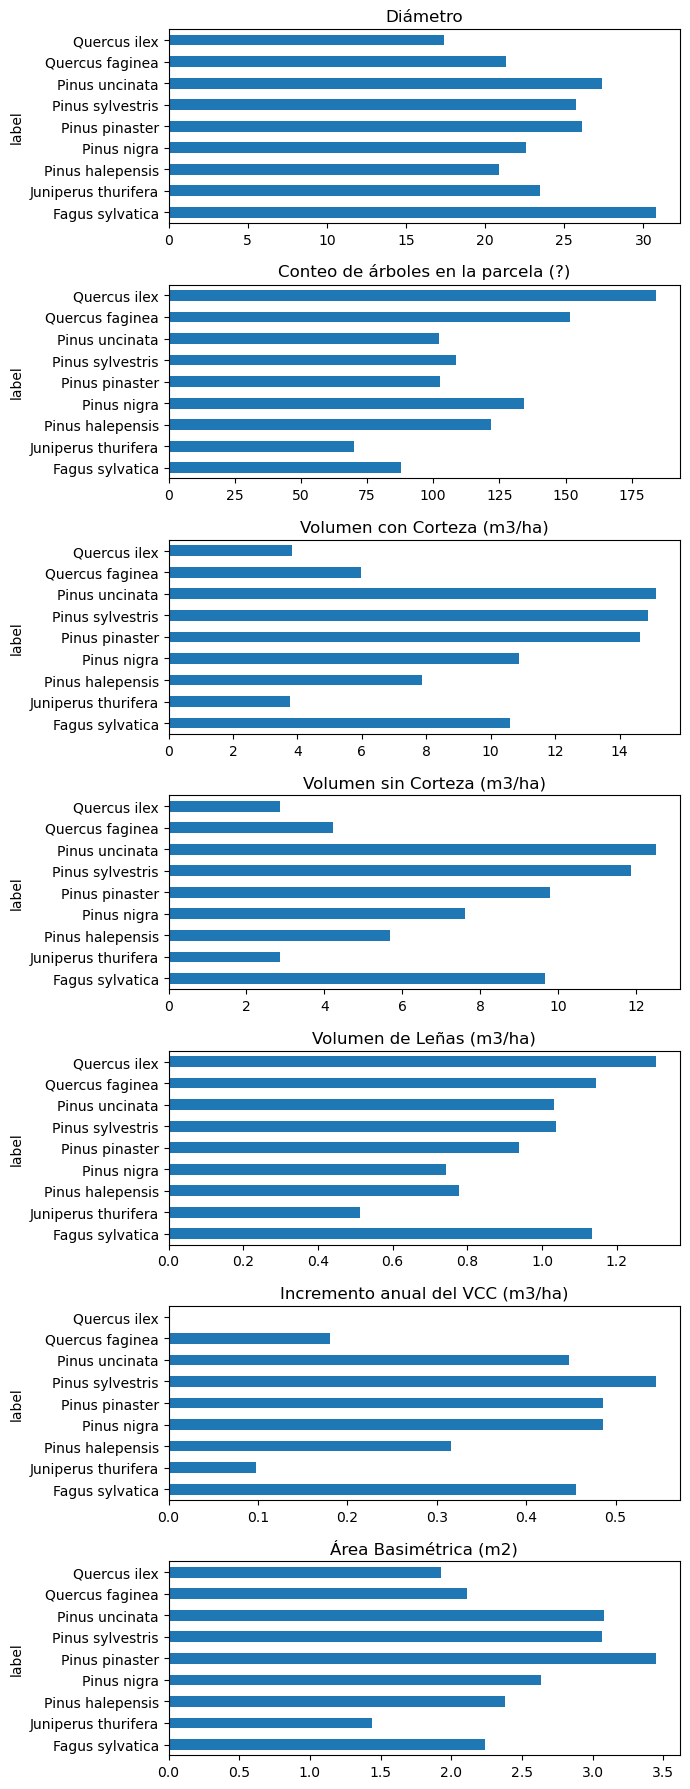

In [109]:
drop_cols = ['PROVINCIA', 'ESTADILLO', 'CESPECIE']
ccd_df = iifl_df.groupby(['label']).mean().drop(columns=drop_cols)
fig, axs = plt.subplots(7, 1, figsize=(7, 18), sharey=True)
for i, col_name in enumerate(ccd_df.columns.to_list()):
    ccd_df[col_name].plot(kind="barh", ax=axs[i])
    axs[i].set_title(iifl_col_names[col_name])
fig.tight_layout()

### Área Basimétrica

> Se conoce como área basimétrica de una masa forestal la suma de las secciones de los árboles a 1.30 m del suelo expresada en metros cuadrados por hectárea. (Cuevas, González-Alonso, y Vázquez 2000)

El área basimétrica varía según la especie, siendo mayor la de *Pinus pinaster*.

In [110]:
# Compute the stats by estaillo
ifn2.ifl_stats()

In [111]:
# Columns to keep from IIFL DB
join_cols = ["ESTADILLO", "PROVINCIA", "CESPECIE"]
target_cols = ["mean_areab", "n_arb"]
datest_iifl = datest_prun.join(
    ifn2.ifl_df.set_index(join_cols)[target_cols],
    on = ["ESTADILLO", "PROVINCIA", "ESPECIE1"])

Los valores máximo de la media de área basal aumentan con la ocupación y la fracción de cabida cubierta. Además, solo existen valores de área basal en puntos de USO2 == 1.

<Axes: xlabel='FRACCION2', ylabel='mean_areab'>

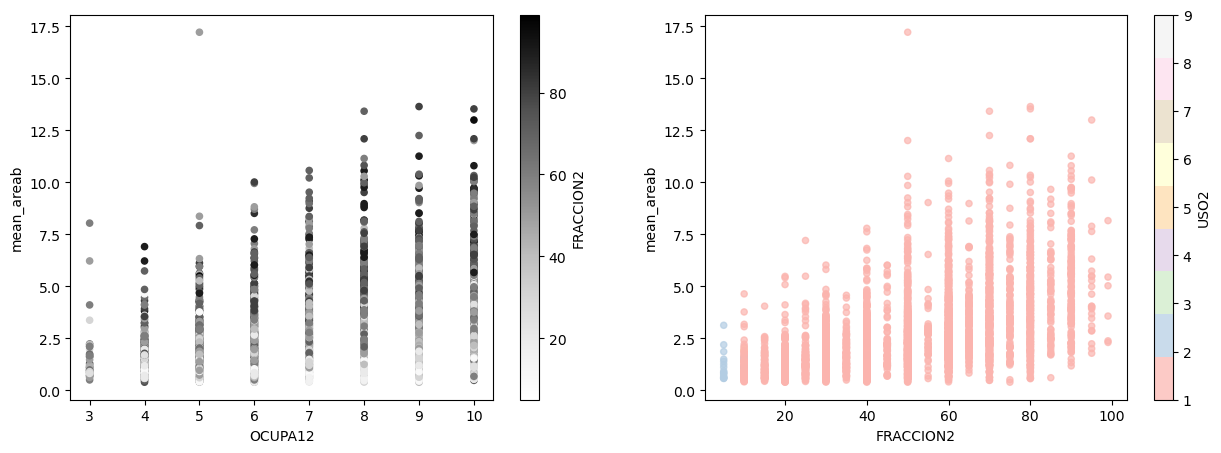

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
datest_iifl.plot(kind="scatter", x="OCUPA12", y="mean_areab", c="FRACCION2", ax=axs[0])
datest_iifl.plot(kind="scatter", x="FRACCION2", y="mean_areab", c="USO2", cmap="Pastel1", ax=axs[1], alpha=0.7)

## Conclusiones

La métrica indicada para filtrar estadillos para la creación de etiquetas es la FCC. El motivo, está relacionada con el porcentaje de cobertura de la especie principal en la parcela. Esto es importante a la hora de clasificarlas con Landsat, donde el dosel vegetal es clave para la identificación de especies. Se ha filtrado también por la ocupación de la primera especie, que deberá ser de al menos un 40%.

La ocupación no es una variable del todo fiable, ya que esta puede ser alta y tener un valor de FCC bajo. Esto quiere decir que hay muchos árboles pero con poco dosel vegetal. Además, algunos errores que se han observado en columnas como el Estado o la Composición específica se mantienen filtrando por ocupación, ya que su promedio tiene ocupaciones altas. Esto no sucede con la FCC.

Se utiliza un umbral de 20 para seleccionar las parcelas forestales. Los promedios de FCC en las categorías Quercus ilex y Juniperus thurifera son bajos, entorno al 30%. De esta forma se asegura que se integran también estas clases.

Los puntos de matorral se seleccionan en función de los daños observados por fuego y el tipo de uso (existe uso de matorral). Además, también se seleccionan aquellos puntos que se sitúan en una zona quemada hace no más de diez años. Estas últimas, teniendo en cuenta que los años de realización del IFN2 en Aragón son principalmente 1993 y 1994, se deberían haber quemado entre 1883 y 1992.

Se seleccionan primero los puntos de matorral, evitando así que se vuelvan a incluir en puntos con vegetación forestal.

In [3]:
# Make the process again to avoid errors
ifn2 = Second(Path(ROOT, r"data\labels\ifn\ifn2"))

# Add coordinates
coord_path = Path(ROOT, "data/labels/ifn/coordinates/IFN4_crs_oficial.csv")
coord = pd.read_csv(coord_path)
ifn2.datest_df = ifn2.datest_df.join(
    coord.set_index(['estadillo', 'provincia']), on=['ESTADILLO', 'PROVINCIA'])

# Create a geodataframe object
x_col = "X_WGS84_4326"
y_col = "Y_WGS84_4326"
crs = 'EPSG:4326'
geom = gpd.points_from_xy(
    ifn2.datest_df[x_col], ifn2.datest_df[y_col], crs=crs)
ifn2.datest_df = gpd.GeoDataFrame(ifn2.datest_df, geometry=geom)

# Add species name and codes
esp_codes_path = Path(ROOT, r"data\labels\label_codes.csv")
esp_codes_df = pd.read_csv(esp_codes_path)
datest_prun = ifn2.datest_df.join(
    esp_codes_df.set_index("code_ifn"), on="ESPECIE1")

In [4]:
# Add fires data to IFN points
fires_path = Path(ROOT, "data/fires.gpkg")
fires = gpd.read_file(fires_path) # EPSG:4326
fires["Year"] = fires["Year"].astype("int16")

estadillos_fires = gpd.sjoin(
    datest_prun, fires, how="inner", predicate="within")

In [5]:
queries_or = [
    # Year of the fire which contains the point
    "Year >= 1983 and Year <= 1992",
    "USO2 == 3",
    "(DANOS1.notnull() & DANOS1.str.endswith('12'))",
    "(DANOS2.notnull() & DANOS2.str.endswith('12'))",
    "(DANOS3.notnull() & DANOS3.str.endswith('12'))"
]

shrub_points = estadillos_fires.query(" or ".join(queries_or))

queries_and = [
    # Only shrub where EPSECIE1 is one of the project ones
    "label.notna()",
    # Only retain points with coordinates
    "X_WGS84_4326.notnull()"
]
shrub_points = shrub_points.query((" and ").join(queries_and))

In [6]:
# Keep the first occurrence and drop the others with the same values in cols
cols = ["ESTADILLO", "PROVINCIA"]
shrub_points = shrub_points.drop_duplicates(subset=cols)

In [7]:
# Update the label code to point shrub labels
shrub_points["code_v1"] = shrub_points["code_v1"] + 10
shrub_points["code_v1"].value_counts().sort_index()

code_v1
11.0    19
12.0     4
13.0     2
14.0     7
15.0     1
16.0     8
17.0    13
19.0     1
Name: count, dtype: int64

In [8]:
# Point set of forestry labels
queries = [
    "FRACCION2 > 20",
    "OCUPA12 >= 4",
    "label.notnull()",
    "USO2 == 1",
    "ANO in [93, 94]",
    # Only retain points with coordinates
    "X_WGS84_4326.notnull()"
]
forest_points = datest_prun.query(" and ".join(queries))
forest_points.shape[0]

2581

In [9]:
# Merge two kind of labels
merge = pd.concat([forest_points, shrub_points]).reset_index()

In [10]:
# Remove duplicates and maintain the shrub one
# Sort so that rows with shrub labels 5 come first
merge.sort_values(by='code_v1', ascending=False)['code_v1']
# For each group of duplicates, keep the first occurrence (shrub label)
merge = merge.drop_duplicates(subset=cols, keep='first')

In [11]:
merge.shape[0]

2626

In [12]:
cols_to_keep = ["ESTADILLO", "PROVINCIA", "ANO", "code_v1", "FRACCION2", "OCUPA12", "geometry"]

# Match year format with four digits from the 3 and 4 NFI
merge["ANO"] = merge["ANO"] + 1900
# Rename columns
merge = merge[cols_to_keep].rename(columns={
    'ANO': 'YEAR',
    'code_v1': 'ESPE',
    'FRACCION2': 'FCC',
    'OCUPA12': 'Ocu1'
})

merge.to_file(Path(ROOT, "data/labels/ifn2_labels.gpkg"))